In [1]:
import pygad 
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import pygad

In [42]:
expected_returns = pd.Series({
'ACWI': 0.07/12,
'^TBSP': 0.049/12,
'XAUPLN': 0.05/12,
'MWIG40': 0.065/12,
'IHYU.L': 0.038/12,
'PLOPLN3M': 0.03/12,
'edo': 0.04/12
})

cov = np.array([[0.001265,	0.000042],
            	[0.000042,	0.000164]])

In [98]:
assets = ['ACWI', '^TBSP']
means = expected_returns[assets]
number_of_scenarios = 10001
T = 60
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov, T))

sim_returns = np.array(sim_returns)
sim_returns.shape

(10001, 60, 2)

In [99]:
sim_means = sim_returns.mean(1)[0].mean()
sim_means*12

0.08517759495240307

In [80]:
sim_means.shape

(501, 2)

In [57]:
class Simulation():
    def __init__(self, initial_value, inflows, returns, strategy) -> None:
        self.capital = initial_value
        self.returns = returns
        self.strategy = strategy 
        self.inflows = inflows
    
   
    def step(self, current_value,inflow,weights,returns):
        current_assets_value = np.expand_dims(current_value,axis=0).T * weights
        next_assets_value =  np.round(current_assets_value * (1+returns),2)
        return next_assets_value.sum(1)
    
        
    def run(self, T):
        for t in range(T):
            self.capital = self.step(self.capital,self.inflows[t],self.strategy[t],self.returns[:,t])


In [58]:
portfolios = [[0.0,1.0],
             [0.1,0.9],
             [0.2,0.8],
             [0.3,0.7],
             [0.4,0.6],
             [0.5,0.5],
             [0.6,0.4],
             [0.7,0.3],
             [0.8,0.2],
             [0.9,0.1],
             [1.0,0.0]]

In [59]:
solution = [9,9,9,7,7,5,5,3,3,2,2]
np.take(portfolios, solution,axis=0)

array([[0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.3, 0.7],
       [0.3, 0.7],
       [0.2, 0.8],
       [0.2, 0.8]])

In [60]:
capital = np.full(501,100)
inflows = np.full(61,0)

T = np.arange(11,60,12)
risk = 10

glide_paths = {}

for t in T:
    perc = []
    for portfolio in range(len(portfolios)):
        solution = np.full(60,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))
    glide_paths[t] = np.argmax(perc)

In [61]:
glide_paths

{11: 2, 23: 1, 35: 1, 47: 2, 59: 2}

In [62]:
r = 0.4
T = 60
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(60,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)
    

In [63]:
solution = np.full(60,2)
fitness(None,solution,0)

125.53

- 2,0.1 - 113
- 8, 0.1 - 100
- 8, 0.4 - 125
- 2, 0.4 - 126

In [64]:
def initial_population(T,number_porfolios,solutions):
    population = np.zeros((solutions,T))
    population[:,0] = np.random.randint(0,number_porfolios+1, solutions)
    for t in range(1,T):
        population[:,t] = np.random.randint(0,population[:,t-1]+1, solutions) 
    return population

In [65]:
initial_pop = initial_population(60,10,100)

In [66]:
sol_per_pop = 100
num_genes = 60
num_parents_mating = 10
keep_parents = 2
gene_type= int
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
parent_selection_type = 'tournament'
crossover_type = "single_point"
num_generations= 200
fitness_function = fitness
mutation_type = "random"
mutation_percent_genes = 10
random_mutation_min_val=-2.0
random_mutation_max_val=2.0
mutation_probability=0.4
crossover_probability=0.4

In [67]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       #sol_per_pop=sol_per_pop,
                       initial_population = initial_pop,
                       #num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gen_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       mutation_probability=mutation_probability,
                       crossover_probability=crossover_probability)

In [68]:
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [71]:
print(solution)
print(solution_fitness)

[ 8  8 10  0  6  4  0  8  0  5  5  3  2  2  3  1  9  1  1  9  7  8  0  9
  0  5  1  9  1  9  0  6 10  7  7  3  9  5  2  6  0  8  3 10  9  8  5 10
  4  3  8 10  8  1  5 10  9  8  6  7]
129.49


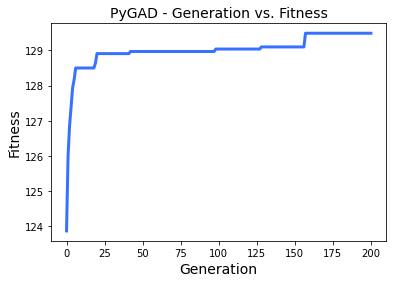

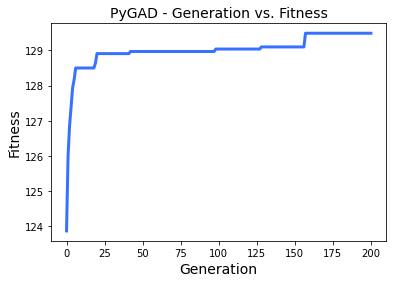

In [72]:
ga_instance.plot_fitness()

[ 0  0  0  7  3  0  8  6  0  5  4  2  8  4  1 10  6  8  9  3  9 10  8  9
  9  3  4  7  1  5  3  3  7  5  1 10 10  9  8  4  4  4  5  9  7  6  5  5
  6  8  5  1  3  9  2  4  5  2  0  7]
129.62